# Fundamental Limits to Predictability

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

### Relationship between summed mutual hill radii and instability time
First, I'm getting the slope of instability time, finding the appropriate mapping between the sum of initial spacing and the resulting instability time. Only the first part of the curve is fit so that things don't saturate at 1e7 orbits. I'm assuming that the slope of this fit extends to e.g. 1e9 orbits

In [99]:
data = pd.read_csv("ariSI.csv",header=0) 
data["delta_sum"] = data["daOverRH1"] + data["daOverRH2"]

sum_thresh = 13
insta_thresh=1e7
Unstable = data[(data["delta_sum"]<sum_thresh) & (data["Norbits_instability"]<insta_thresh)]
delta_sum = Unstable["daOverRH1"] + Unstable["daOverRH2"]
log_insta = np.log10(Unstable["Norbits_instability"])

best fit line: y=0.38x + 0.211558


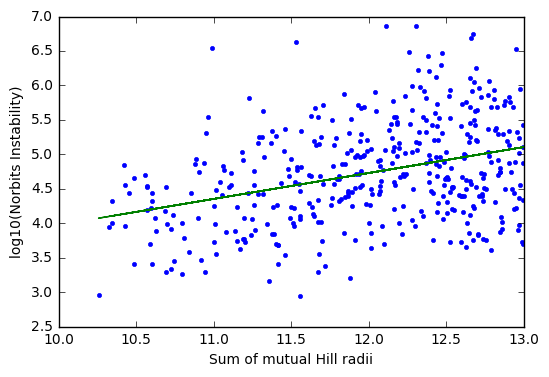

In [100]:
def line(x,m,b):
    return m*x + b

popt, pcov = curve_fit(line, delta_sum, log_insta)

plt.plot(delta_sum, log_insta, '.')
plt.plot(delta_sum,popt[0]*delta_sum + popt[1])
plt.ylabel('log10(Norbits Instability)')
plt.xlabel('Sum of mutual Hill radii')
print "best fit line: y=%.2fx + %2f"%(popt[0], popt[1])

### Standard deviation of instability time
Here I'm getting the standard deviation of the instability time for a given system. I could also likely get this from the scatter in the above figure, which tends to agree with the results below (i.e. the standard deviation is about 3 orders of magnitude in instability time).

(0.33842394197506276, 0.45825131257629032)


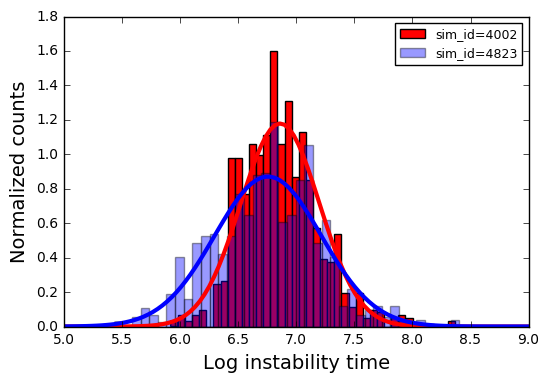

In [40]:
#get standard deviation of instability time
sim_id = 4002
#df = pd.read_csv("/mnt/raid-cita/dtamayo/Stability/data/distribution/outputs"+str(sim_id)+'/distribution'+str(sim_id)+".csv", index_col=0)
df = pd.read_csv("../data/distribution/outputs"+str(sim_id)+'/distributionallfeatures'+str(sim_id)+".csv", index_col=0)
df.tail()

sim_id = 4283
#df2 = pd.read_csv("/mnt/raid-cita/dtamayo/Stability/data/distribution/outputs"+str(sim_id)+'/distribution'+str(sim_id)+".csv", index_col=0)
df2 = pd.read_csv("../data/distribution/outputs"+str(sim_id)+'/distributionallfeatures'+str(sim_id)+".csv", index_col=0)
df2.tail()
logs1 = np.log10(df['Norbits_instability'].values)
logs2 = np.log10(df2['Norbits_instability'].values)

from scipy.stats import norm
import matplotlib.mlab as mlab
mu1, std1 = norm.fit(logs1)
mu2, std2 = norm.fit(logs2)
std_avg = np.mean([std1,std2])
x = np.linspace(5, 9, 100)

fontsize=14
fig, ax = plt.subplots()
ax.hist(logs1, 40, normed=True, label='sim_id=4002', color="red")
ax.hist(logs2, 40, alpha=0.4, normed=True, label='sim_id=4823', color="blue")
ax.plot(x, mlab.normpdf(x, mu1, std1), color="red", lw=3)
ax.plot(x, mlab.normpdf(x, mu2, std2), color="blue", lw=3)
ax.set_xlabel('Log instability time', fontsize=fontsize)
ax.set_ylabel('Normalized counts', fontsize=fontsize)
plt.legend(loc="upper right",fontsize=9)
print(np.std(logs1),np.std(logs2))

### Monte Carlo fundamental limits for predicting instability
Using the mapping between initial spacing and instability time, and the standard deviation of instability times, one can predict the fundamental limits for instability. The key assumption made here is that the machine learning algorithm always assigns a given system as stable/unstable according to whether the majority of samples in its gaussian distribution are stable/unstable. E.g. if 80% of the samples in a certain gaussian distribution have Norbits_instability > stable_thresh, then it is assumed the machine learning algorithm will always classify the system as stable, yielding a 20% error (20% of the time the system is unstable, but the machine learning algorithm always predicts the system is stable).

In [104]:
#MC
stable_thresh = 7   #if a system survives beyond 10^stable_thresh it is considered stable 
N_draws = 10000     #How many simulated systems?

#set up various ranges and such
range_ = np.linspace(stable_thresh - 4,stable_thresh+4,100)
unstable_range_ = np.where(range_ < stable_thresh)
stable_range_ = np.where(range_ >= stable_thresh)
error = 0

#MC
a = np.zeros(N_draws)
for i in xrange(N_draws):
    delta_sum = np.random.uniform(5,10) + np.random.uniform(5,10) #generate system
    a[i] = delta_sum
    sample_Ninsta = popt[0]*delta_sum + popt[1]                 #convert to instability time from above fit
    sample_gauss = mlab.normpdf(range_, sample_Ninsta, std_avg) #create gaussian for sample
    sum_unstable = sum(sample_gauss[unstable_range_])/sum(sample_gauss) #fraction of gaussian that is unstable
    sum_stable = sum(sample_gauss[stable_range_])/sum(sample_gauss) #fraction of gaussian that is stable
    error += min(sum_unstable, sum_stable)                      #add misclassification error

print "The fundamental limit of predictability (i.e. the best possible performance of the machine learning algorithm) is:\n %f"%(1.0 - error/N_draws)
#plt.plot(range_, sample_gauss)
#plt.plot([stable_thresh, stable_thresh],[0,1], 'r--')

The fundamental limit of predictability (i.e. the best possible performance of the machine learning algorithm) is:
 0.933195
